## 어탠션의 구조
어탠션 매커니즘은 seq2seq 를 더 강력하게 해준다.

seq2seq가 인간처럼 필요한 정보에만 주목할 수 있게 해주고, 기존의 seq2seq 가 갖고있던 문제점도 해결가능하다.

### seq2seq의 문제점은 무엇일까?
seq2seq 에서 encoder 가 시계열데이터를 인코딩하고, 그 인코딩된 정보를 decoder로 전달하는데, 이때 encoder 의 출력은 '고정 길이의 벡터'였다. 이 '고정 길이'에 문제점이 잠재해 있는 것이다. 아무리 입력 문장의 길이가 길다 하더라도 같은 길이의 벡터로 변환한다는 뜻이다. 이는 결국, 필요한 정보가 벡터에 다 담기지 못하는 문제가 생긴다. 그래서 우선 encoder를 개선하고 이어서 decoder 도 개선해야 한다.

### Encoder 개선
우선, encoder를 개선해보자.

개선 포인트는, encoder 출력의 길이를 입력 문장의 길이에 따라 바꿔주는 것이다.
그러기 위해서, 시각별(=단어별) LSTM 계층의 은닉 상태 벡터를 모두 이용하는 것이다.
예를들어, 5개 단어가 입력되었으면, encoder는 5개의 벡터를 출력한다.

그러면 각 시각별 LSTM 계층의 은닉 상태에는 어떤 정보가 담겨있을까? 직전에 입력된 단어에 대한 정보가 많이 포함되어있을 것이다. 따라서, encoder가 출력하는 hs 행렬은 각 단어에 해당하는 벡터들의 집합일 것이다.

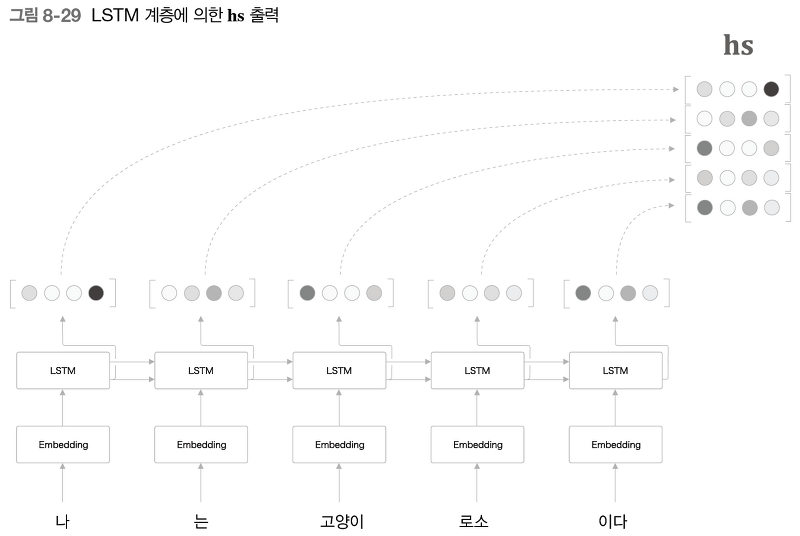

### DEcoder 개선

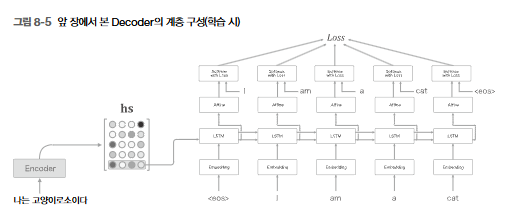

우리가 지금까지 접근했던 방식 ^

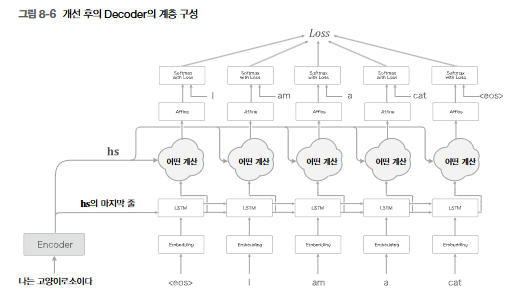

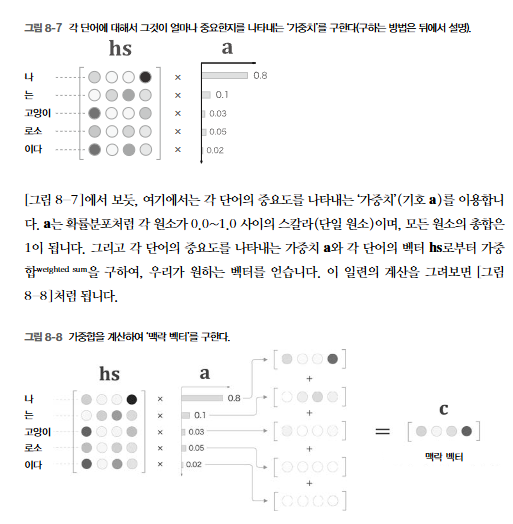

In [8]:
import numpy as np

T,H=5,4
hs=np.random.randn(T,H)

print(hs)

a=np.array([0.8,0.1,0.01,0.05,0.02])
ar=a.reshape(5,1).repeat(4,axis=1)

print(ar)
print((hs*ar).shape)
np.sum(hs*ar,axis=0)

[[-1.30330647  0.37321873 -1.7561764   0.33344858]
 [-0.82618688 -0.79708301 -0.6723264  -0.80136708]
 [-1.47288448  1.27577181 -0.282743    1.2091338 ]
 [ 0.5384669  -0.67032969 -1.58585771  2.16152823]
 [-0.81364585  0.7885752   0.75519189 -0.1245235 ]]
[[0.8  0.8  0.8  0.8 ]
 [0.1  0.1  0.1  0.1 ]
 [0.01 0.01 0.01 0.01]
 [0.05 0.05 0.05 0.05]
 [0.02 0.02 0.02 0.02]]
(5, 4)


array([-1.12934228,  0.21387942, -1.53919024,  0.30429944])

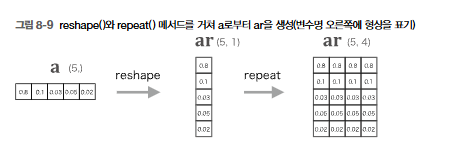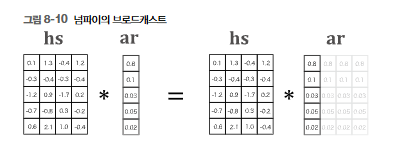

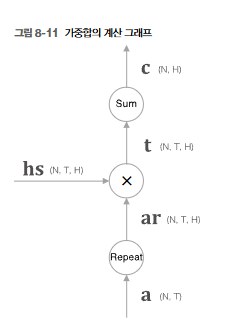

In [10]:
import numpy as np

N,T,H=10,5,4
hs=np.random.randn(N,T,H)
a=np.random.randn(N,T)
ar=a.reshape(N,T,1).repeat(H,axis=2) # 가중치를 맞춰줌

print(ar.shape)

t=hs*ar
print(t.shape)

C=np.sum(t,axis=1)
print(C)
print(C.shape)

(10, 5, 4)
(10, 5, 4)
[[-1.12705556e+00 -5.20395556e+00 -2.17603003e+00  3.18588303e-01]
 [ 1.00023888e+00 -1.14929588e+00 -6.06360341e-02  1.94405918e+00]
 [-8.27672365e-01 -1.43550861e+00  2.84217155e+00 -2.11914406e+00]
 [-2.84516727e+00 -5.38753381e-01  1.16104515e-01 -2.38925422e-01]
 [-2.46275646e+00 -1.22728505e+00 -2.15190637e+00 -1.58753033e+00]
 [-8.86267952e-01  2.22839223e+00  3.11980728e+00 -3.22772879e+00]
 [ 7.57675438e-01 -3.71828717e+00  4.03907790e+00  4.68116462e+00]
 [-9.41172313e-04 -6.31585584e-01 -3.98384307e+00  3.40296249e+00]
 [ 2.65542623e+00  3.74091156e+00 -3.10118079e+00  3.83278063e+00]
 [ 7.65412174e-01 -1.36241356e+00  9.99656767e-01  1.63929622e+00]]
(10, 4)


In [11]:
class WeightSum:
    def __init__(self):
        """
        WeightSum 클래스 초기화
        
        이 클래스는 가중치 합을 계산하는 계층을 구현합니다.
        
        예시:
        >>> ws = WeightSum()
        >>> hs = np.array([[[1.0, 2.0], [3.0, 4.0]], [[5.0, 6.0], [7.0, 8.0]]])  # shape=(2, 2, 2)
        >>> a = np.array([[0.2, 0.8], [0.5, 0.5]])  # shape=(2, 2)
        >>> output = ws.forward(hs, a)
        >>> print(output)  # 예시 출력: [[2.4 3.6], [6.0 7.0]]
        """
        self.params, self.grads = [], []  # 매개변수와 기울기 초기화
        self.cache = None  # 캐시 초기화

    def forward(self, hs, a):
        """
        순전파 메서드
        
        Args:
        - hs (numpy.ndarray): 입력 은닉 상태, shape=(N, T, H)
        - a (numpy.ndarray): 가중치, shape=(N, T)

        Returns:
        - c (numpy.ndarray): 가중치 합, shape=(N, H)
        """
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)  # 가중치 차원 변환
        t = hs * ar  # 가중치와 은닉 상태 곱셈
        c = np.sum(t, axis=1)  # 가중치 합 계산

        self.cache = (hs, ar)  # 캐시 저장
        return c

    def backward(self, dc):
        """
        역전파 메서드
        
        Args:
        - dc (numpy.ndarray): 손실 기울기, shape=(N, H)

        Returns:
        - dhs (numpy.ndarray): 은닉 상태에 대한 기울기, shape=(N, T, H)
        - da (numpy.ndarray): 가중치에 대한 기울기, shape=(N, T)
        """
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)  # 손실 기울기 차원 변환
        dar = dt * hs  # 가중치에 대한 기울기 계산
        dhs = dt * ar  # 은닉 상태에 대한 기울기 계산
        da = np.sum(dar, axis=2)  # 가중치 기울기 합계

        return dhs, da


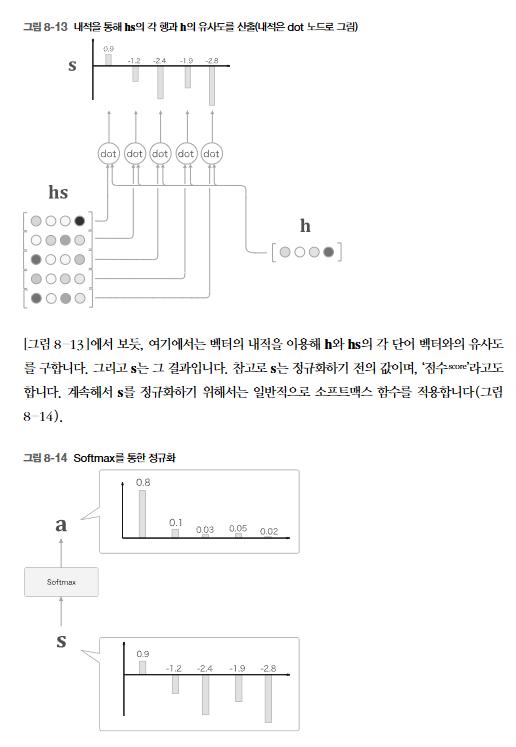

In [15]:
import sys
sys.path.append('..')
from common.layers import Softmax 
import numpy as np

# 매개변수 설정
N, T, H = 10, 5, 4  # N: 배치 크기, T: 시퀀스 길이, H: 은닉 상태의 차원

# 랜덤한 은닉 상태 및 h 초기화
hs = np.random.randn(N, T, H)  # shape=(10, 5, 4)
h = np.random.randn(N, H)  # shape=(10, 4)

# h를 (N, 1, H)로 변형하고 T에 맞게 반복
hr = h.reshape(N, 1, H).repeat(T, axis=1)  # hr의 shape은 (10, 5, 4)

# hs와 hr의 요소별 곱
t = hs * hr  # 각 시간 단계의 은닉 상태와 h의 요소별 곱
print(t.shape)  # (10, 5, 4)

# 차원 H에 대해 합산
s = np.sum(t, axis=2)  # 각 시퀀스에 대한 가중치 합산, shape은 (10, 5)
print(s.shape)  # (10, 5)

# 소프트맥스 계층 초기화 및 순전파
softmax = Softmax() 
a = softmax.forward(s)  # s에 대한 소프트맥스 계산
print(a.shape)  # (10, 5) - 소프트맥스 결과


(10, 5, 4)
(10, 5)
(10, 5)


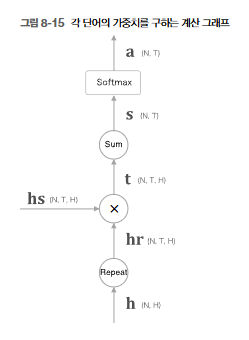

In [16]:
class AttentionWeight:
    def __init__(self):
        """
        AttentionWeight 클래스는 주어진 입력 상태(hs)와 은닉 상태(h)를 바탕으로
        attention 가중치를 계산하는 모듈입니다.

        Attributes:
            params: 이 클래스에서는 파라미터가 없습니다.
            grads: 이 클래스에서는 그래디언트가 없습니다.
            softmax: Softmax 계층 인스턴스.
            cache: forward 함수에서 사용하는 캐시.
        """
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        """
        주어진 은닉 상태(hs)와 입력 상태(h)를 기반으로 attention 가중치를 계산합니다.

        Args:
            hs (ndarray): (N, T, H) 형태의 은닉 상태 배열.
            h (ndarray): (N, H) 형태의 입력 상태 배열.

        Returns:
            a (ndarray): attention 가중치 배열, shape는 (N, T)입니다.

        예시:
            >>> N, T, H = 2, 3, 4
            >>> hs = np.random.rand(N, T, H)
            >>> h = np.random.rand(N, H)
            >>> attention_weight = AttentionWeight()
            >>> a = attention_weight.forward(hs, h)
            >>> print("Attention Weights:\n", a)
        """
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)  # h를 (N, 1, H) 형태로 변형
        t = hs * hr              # hs와 hr의 element-wise 곱
        s = np.sum(t, axis=2)    # 각 T에 대해 합산
        a = self.softmax.forward(s)  # Softmax를 적용하여 가중치 계산

        self.cache = (hs, hr)    # 캐시에 hs와 hr 저장
        return a

    def backward(self, da):
        """
        attention 가중치에 대한 그래디언트를 계산합니다.

        Args:
            da (ndarray): backward로 전달된 gradient 배열, shape는 (N, T)입니다.

        Returns:
            dhs (ndarray): hs에 대한 그래디언트, shape는 (N, T, H)입니다.
            dh (ndarray): h에 대한 그래디언트, shape는 (N, H)입니다.
        """
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)  # Softmax의 backward 호출
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)  # ds를 (N, T, 1) 형태로 변형 후 H 차원으로 반복
        dhs = dt * hr                    # dhs 계산
        dhr = dt * hs                    # dhr 계산
        dh = np.sum(dhr, axis=1)         # h에 대한 그래디언트 계산

        return dhs, dh


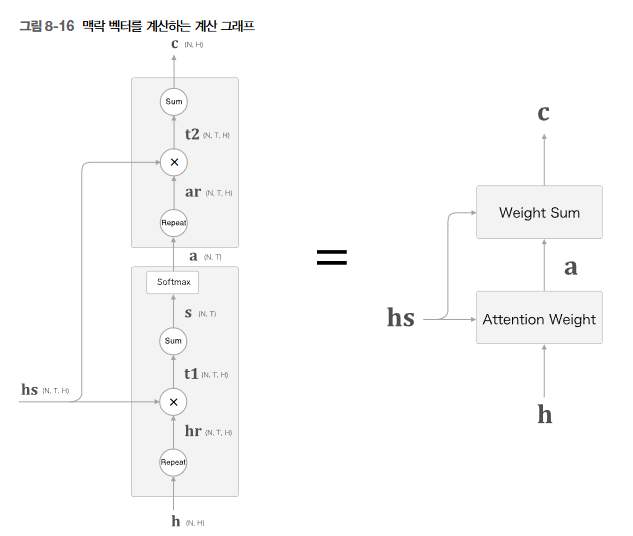
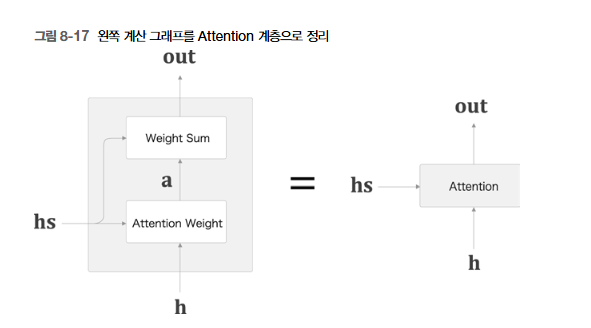

In [17]:
class Attention:
    def __init__(self):
        """
        Attention 클래스는 입력 상태(hs)와 은닉 상태(h)를 기반으로 
        attention 메커니즘을 구현합니다. 이 클래스는 attention 가중치와 가중합을 계산합니다.

        Attributes:
            params: 이 클래스에서는 파라미터가 없습니다.
            grads: 이 클래스에서는 그래디언트가 없습니다.
            attention_weight_layer: AttentionWeight 인스턴스.
            weight_sum_layer: WeightSum 인스턴스.
            attention_weight: 최근 계산된 attention 가중치.
        """
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()  # Attention 가중치 레이어 인스턴스
        self.weight_sum_layer = WeightSum()              # 가중합 레이어 인스턴스
        self.attention_weight = None                      # attention 가중치 초기화

    def forward(self, hs, h):
        """
        주어진 은닉 상태(hs)와 입력 상태(h)를 기반으로 attention 가중치를 계산하고
        가중합을 수행합니다.

        Args:
            hs (ndarray): (N, T, H) 형태의 은닉 상태 배열.
            h (ndarray): (N, H) 형태의 입력 상태 배열.

        Returns:
            out (ndarray): 가중합 결과 배열, shape는 (N, H)입니다.

        예시:
            >>> N, T, H = 2, 3, 4
            >>> hs = np.random.rand(N, T, H)
            >>> h = np.random.rand(N, H)
            >>> attention = Attention()
            >>> out = attention.forward(hs, h)
            >>> print("Attention Output:\n", out)
        """
        a = self.attention_weight_layer.forward(hs, h)  # attention 가중치 계산
        out = self.weight_sum_layer.forward(hs, a)       # 가중합 계산
        self.attention_weight = a                          # 최근 계산된 attention 가중치 저장
        return out

    def backward(self, dout):
        """
        backward 호출 시 그래디언트를 계산합니다.

        Args:
            dout (ndarray): backward로 전달된 gradient 배열, shape는 (N, H)입니다.

        Returns:
            dhs (ndarray): hs에 대한 그래디언트, shape는 (N, T, H)입니다.
            dh (ndarray): h에 대한 그래디언트, shape는 (N, H)입니다.

        예시:
            >>> dhs, dh = attention.backward(dout)
            >>> print("Gradient with respect to hs:\n", dhs)
            >>> print("Gradient with respect to h:\n", dh)
        """
        dhs0, da = self.weight_sum_layer.backward(dout)  # 가중합 레이어의 backward 호출
        dhs1, dh = self.attention_weight_layer.backward(da)  # AttentionWeight 레이어의 backward 호출
        dhs = dhs0 + dhs1                                    # hs에 대한 그래디언트 합산
        return dhs, dh                                       # 결과 반환

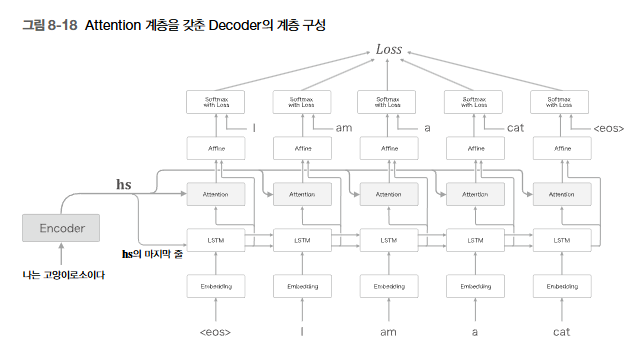

In [18]:
class TimeAttention:
    def __init__(self):
        """
        TimeAttention 클래스는 시간적 차원에서 attention 메커니즘을 적용합니다.
        이 클래스는 인코더의 은닉 상태(hs_enc)와 디코더의 은닉 상태(hs_dec)를 기반으로
        각각의 시간 단계에서 attention 가중치를 계산합니다.

        Attributes:
            params: 이 클래스에서는 파라미터가 없습니다.
            grads: 이 클래스에서는 그래디언트가 없습니다.
            layers: 각 시간 단계에서 사용된 Attention 레이어를 저장하는 리스트입니다.
            attention_weights: 각 시간 단계에서 계산된 attention 가중치를 저장하는 리스트입니다.
        """
        self.params, self.grads = [], []
        self.layers = None              # Attention 레이어를 저장할 리스트
        self.attention_weights = None    # attention 가중치를 저장할 리스트

    def forward(self, hs_enc, hs_dec):
        """
        인코더의 은닉 상태(hs_enc)와 디코더의 은닉 상태(hs_dec)를 입력으로 받아
        각 시간 단계에서 attention 가중치를 계산하고 가중합을 수행합니다.

        Args:
            hs_enc (ndarray): (N, T_enc, H) 형태의 인코더 은닉 상태 배열.
            hs_dec (ndarray): (N, T_dec, H) 형태의 디코더 은닉 상태 배열.

        Returns:
            out (ndarray): 각 시간 단계에서의 가중합 결과 배열, shape는 (N, T_dec, H)입니다.

        예시:
            >>> N, T_enc, T_dec, H = 2, 3, 4, 5
            >>> hs_enc = np.random.rand(N, T_enc, H)
            >>> hs_dec = np.random.rand(N, T_dec, H)
            >>> time_attention = TimeAttention()
            >>> out = time_attention.forward(hs_enc, hs_dec)
            >>> print("Attention Output:\n", out)
        """
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()  # 각 시간 단계마다 Attention 인스턴스 생성
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])  # attention 가중합 계산
            self.layers.append(layer)  # 레이어 저장
            self.attention_weights.append(layer.attention_weight)  # attention 가중치 저장

        return out

    def backward(self, dout):
        """
        backward 호출 시 그래디언트를 계산합니다.

        Args:
            dout (ndarray): backward로 전달된 gradient 배열, shape는 (N, T_dec, H)입니다.

        Returns:
            dhs_enc (ndarray): 인코더 은닉 상태(hs_enc)에 대한 그래디언트, shape는 (N, T_enc, H)입니다.
            dhs_dec (ndarray): 디코더 은닉 상태(hs_dec)에 대한 그래디언트, shape는 (N, T_dec, H)입니다.

        예시:
            >>> dhs_enc, dhs_dec = time_attention.backward(dout)
            >>> print("Gradient with respect to hs_enc:\n", dhs_enc)
            >>> print("Gradient with respect to hs_dec:\n", dhs_dec)
        """
        N, T, H = dout.shape
        dhs_enc = 0  # 인코더에 대한 그래디언트 초기화
        dhs_dec = np.empty_like(dout)  # 디코더에 대한 그래디언트 초기화

        for t in range(T):
            layer = self.layers[t]  # 현재 시간 단계의 레이어 가져오기
            dhs, dh = layer.backward(dout[:, t, :])  # 레이어의 backward 호출
            dhs_enc += dhs  # 인코더 그래디언트 누적
            dhs_dec[:, t, :] = dh  # 디코더 그래디언트 저장

        return dhs_enc, dhs_dec  # 결과 반환


# 사용 예시
if __name__ == "__main__":
    N, T_enc, T_dec, H = 2, 3, 4, 5  # 예시 데이터의 차원 설정
    hs_enc = np.random.rand(N, T_enc, H)  # 랜덤으로 생성된 인코더 은닉 상태 배열
    hs_dec = np.random.rand(N, T_dec, H)  # 랜덤으로 생성된 디코더 은닉 상태 배열

    time_attention = TimeAttention()  # TimeAttention 인스턴스 생성
    out = time_attention.forward(hs_enc, hs_dec)  # forward 호출하여 attention 가중합 계산
    print("Attention Output:\n", out)

    dout = np.random.rand(N, T_dec, H)  # backward 호출을 위한 랜덤 gradient 배열
    dhs_enc, dhs_dec = time_attention.backward(dout)  # backward 호출
    print("Gradient with respect to hs_enc:\n", dhs_enc)
    print("Gradient with respect to hs_dec:\n", dhs_dec)


Attention Output:
 [[[0.46127843 0.67948113 0.41861681 0.41766441 0.42853828]
  [0.49346935 0.65665871 0.41358619 0.37085991 0.44568532]
  [0.50336525 0.59927286 0.39136979 0.35261943 0.47325054]
  [0.46212157 0.65825808 0.41002121 0.41486114 0.43811626]]

 [[0.6999666  0.3215899  0.46132866 0.53244102 0.38334297]
  [0.69192437 0.37208478 0.51208398 0.43665192 0.38330316]
  [0.69383953 0.36292569 0.50884109 0.46271299 0.3887512 ]
  [0.69349293 0.35753976 0.48769048 0.45000814 0.37439771]]]
Gradient with respect to hs_enc:
 [[[0.40560409 0.21248238 0.90293824 0.08820489 0.72089631]
  [0.33442776 0.22660276 0.75543634 0.15131789 0.54681641]
  [0.90605876 0.66571629 1.51392358 0.46534531 1.25788674]]

 [[0.53116769 0.11909372 0.23088217 0.12880798 0.11800279]
  [1.18460226 0.54265985 1.06749553 0.71987167 0.63207504]
  [1.16770833 0.6160302  0.9488365  0.62661161 0.59757576]]]
Gradient with respect to hs_dec:
 [[[ 0.04532862  0.00618792  0.00864327 -0.06297531  0.00718238]
  [-0.00138114 

In [20]:
from common.seq2seq import Encoder, Seq2seq
class AttentionEncoder(Encoder):
    def forward(self, xs):
        """
        입력 데이터(xs)를 인코딩하여 은닉 상태(hs)를 계산합니다.

        Args:
            xs (ndarray): 입력 데이터 배열, shape는 (N, T)입니다.
        
        Returns:
            hs (ndarray): 인코딩된 은닉 상태 배열, shape는 (N, T, H)입니다.

        예시:
            >>> xs = np.array([[1, 2, 3], [4, 5, 6]])  # 입력 데이터
            >>> attention_encoder = AttentionEncoder(vocab_size=10, wordvec_size=5, hidden_size=4)
            >>> hs = attention_encoder.forward(xs)
            >>> print("Encoded hidden states:\n", hs)
        """
        xs = self.embed.forward(xs)  # 입력 데이터를 임베딩
        hs = self.lstm.forward(xs)    # LSTM을 통해 은닉 상태 계산
        return hs

    def backward(self, dhs):
        """
        출력 그래디언트(dhs)를 입력 임베딩과 LSTM 레이어에 대한 그래디언트로 변환합니다.

        Args:
            dhs (ndarray): 출력 그래디언트 배열, shape는 (N, T, H)입니다.

        Returns:
            dout (ndarray): 임베딩 레이어에 대한 그래디언트, shape는 (N, T)입니다.

        예시:
            >>> dhs = np.random.rand(2, 3, 4)  # 출력 그래디언트
            >>> dout = attention_encoder.backward(dhs)
            >>> print("Gradient with respect to inputs:\n", dout)
        """
        dout = self.lstm.backward(dhs)  # LSTM의 backward 호출
        dout = self.embed.backward(dout) # 임베딩 레이어의 backward 호출
        return dout  # 임베딩 레이어에 대한 그래디언트 반환

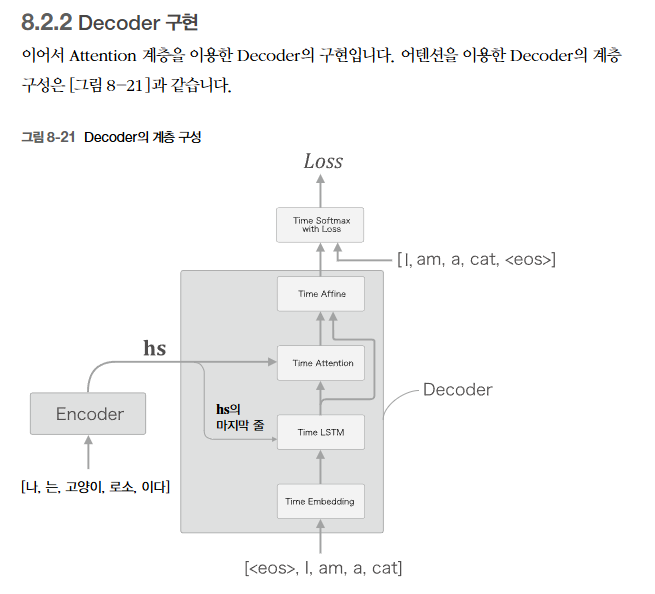

In [22]:
from common.time_layers import *

class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        """
        Attention 기반 디코더 클래스입니다.

        Args:
            vocab_size (int): 어휘의 크기.
            wordvec_size (int): 단어 벡터의 차원.
            hidden_size (int): LSTM의 은닉 상태 크기.
        """
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2 * H, V) / np.sqrt(2 * H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)  # 임베딩 레이어
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)  # LSTM 레이어
        self.attention = TimeAttention()  # 어텐션 레이어
        self.affine = TimeAffine(affine_W, affine_b)  # Affine 레이어
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        """
        디코더의 순전파를 수행합니다.

        Args:
            xs (ndarray): 입력 데이터 배열, shape는 (N, T)입니다.
            enc_hs (ndarray): 인코더에서 출력된 은닉 상태, shape는 (N, T, H)입니다.

        Returns:
            score (ndarray): 최종 출력 점수, shape는 (N, T, vocab_size)입니다.

        예시:
            >>> xs = np.array([[1, 2, 3], [4, 5, 6]])  # 입력 데이터
            >>> enc_hs = np.random.rand(2, 5, 4)  # 인코더 은닉 상태
            >>> attention_decoder = AttentionDecoder(vocab_size=10, wordvec_size=5, hidden_size=4)
            >>> score = attention_decoder.forward(xs, enc_hs)
            >>> print("Output score shape:", score.shape)
        """
        h = enc_hs[:, -1]  # 인코더의 마지막 은닉 상태 사용
        self.lstm.set_state(h)

        out = self.embed.forward(xs)  # 입력 데이터 임베딩
        dec_hs = self.lstm.forward(out)  # 디코더 LSTM 순전파
        c = self.attention.forward(enc_hs, dec_hs)  # 어텐션 계산
        out = np.concatenate((c, dec_hs), axis=2)  # 어텐션 출력과 LSTM 출력을 연결
        score = self.affine.forward(out)  # 최종 점수 계산

        return score

    def backward(self, dscore):
        """
        디코더의 역전파를 수행합니다.

        Args:
            dscore (ndarray): 출력 점수의 기울기, shape는 (N, T, vocab_size)입니다.

        Returns:
            denc_hs (ndarray): 인코더의 은닉 상태에 대한 기울기, shape는 (N, T, H)입니다.

        예시:
            >>> dscore = np.random.rand(2, 3, 10)  # 가상의 기울기
            >>> denc_hs = attention_decoder.backward(dscore)
            >>> print("Encoder hidden states gradient shape:", denc_hs.shape)
        """
        dout = self.affine.backward(dscore)  # Affine 레이어 역전파
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:, :, :H], dout[:, :, H:]  # 어텐션과 디코더의 기울기 분리
        denc_hs, ddec_hs1 = self.attention.backward(dc)  # 어텐션 역전파
        ddec_hs = ddec_hs0 + ddec_hs1  # 디코더 기울기 합산
        dout = self.lstm.backward(ddec_hs)  # LSTM 역전파
        dh = self.lstm.dh
        denc_hs[:, -1] += dh  # 인코더의 마지막 은닉 상태 기울기 업데이트
        self.embed.backward(dout)  # 임베딩 역전파

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        """
        시퀀스를 생성합니다.

        Args:
            enc_hs (ndarray): 인코더에서 출력된 은닉 상태, shape는 (N, T, H)입니다.
            start_id (int): 시작 단어 ID.
            sample_size (int): 생성할 시퀀스의 길이.

        Returns:
            sampled (list): 생성된 단어 ID 리스트.

        예시:
            >>> enc_hs = np.random.rand(2, 5, 4)  # 인코더 은닉 상태
            >>> start_id = 0  # 시작 단어 ID
            >>> sample_size = 5  # 생성할 시퀀스 길이
            >>> sampled_ids = attention_decoder.generate(enc_hs, start_id, sample_size)
            >>> print("Sampled word IDs:", sampled_ids)
        """
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]  # 인코더의 마지막 은닉 상태 사용
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))  # 현재 단어 ID를 배열 형태로 변환

            out = self.embed.forward(x)  # 단어 ID 임베딩
            dec_hs = self.lstm.forward(out)  # 디코더 LSTM 순전파
            c = self.attention.forward(enc_hs, dec_hs)  # 어텐션 계산
            out = np.concatenate((c, dec_hs), axis=2)  # 어텐션 출력과 LSTM 출력을 연결
            score = self.affine.forward(out)  # 최종 점수 계산

            sample_id = np.argmax(score.flatten())  # 가장 높은 점수의 단어 ID 선택
            sampled.append(sample_id)  # 선택된 단어 ID 추가

        return sampled


In [23]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 4[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 8[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 12[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 16[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 20[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 24[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 27[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 31[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 35[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 39[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 43[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 47[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 50[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 54[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 58[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 62[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 65[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
X 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1978-08-11
---
Q Tuesday, November 22, 2016   

c:\Users\hopio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hopio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hopio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hopio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\hopio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_

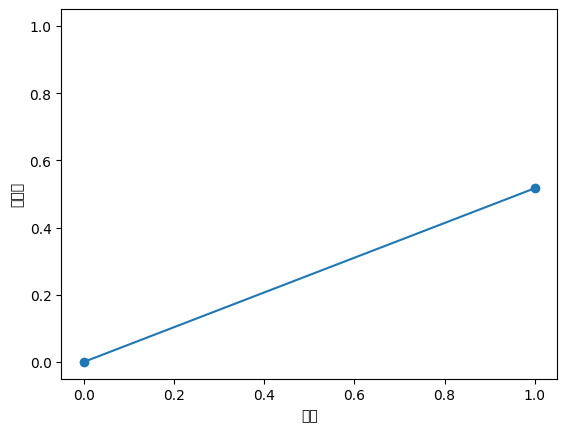

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 2
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

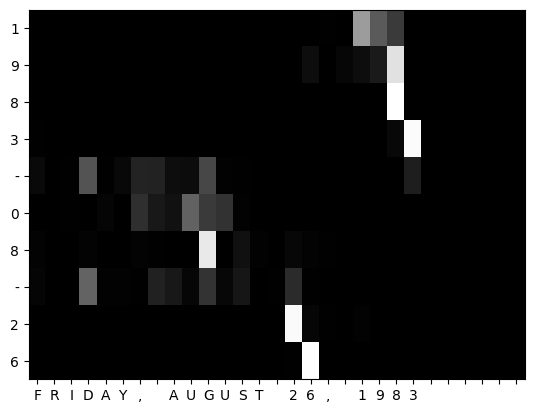

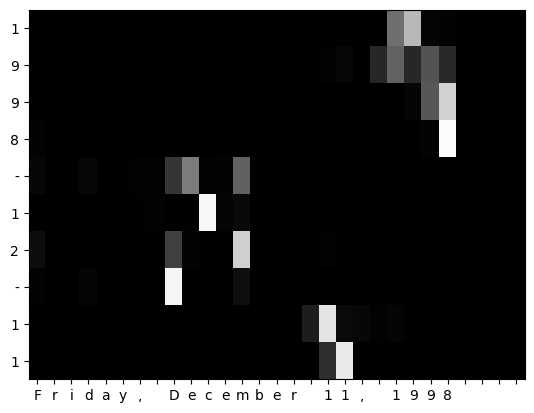

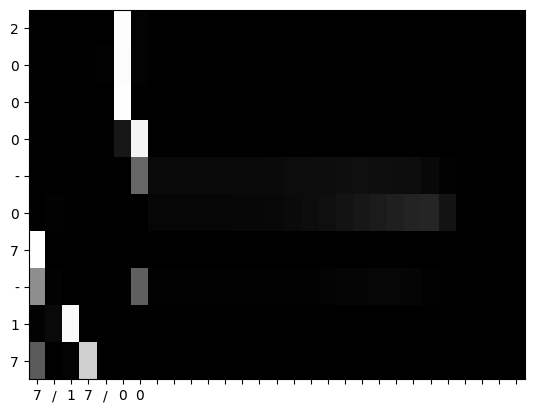

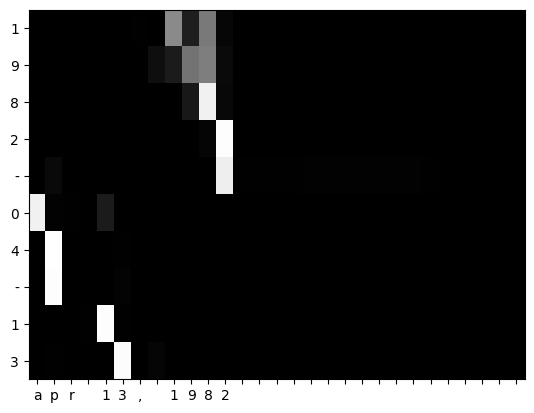

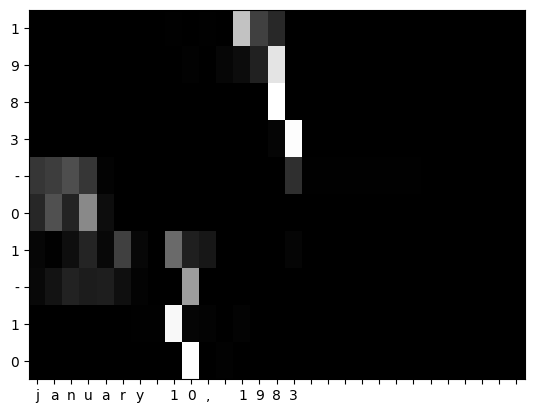

In [26]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)
